In [44]:
import numpy as np
import random
# import skorch
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm.notebook import tqdm
import pandas as pd
from ptsa.data.timeseries import TimeSeries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import LeaveOneGroupOut, cross_validate

#### PYTORCH CONFIGURATION SETTINGS ######
device = "cpu"
#FOR GPU: device = "mps" if torch.has_mps else "cpu"
print(f"Using {device} device")

Using cpu device


### Logistic Regression PyTorch implementation

In [130]:
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        
class LogisticRegressionTorch(torch.nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        self.logistic = torch.nn.Sequential(
            torch.nn.Linear(input_dim, output_dim, bias=True),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        # logits = torch.sigmoid(self.linear(x))
        probs = self.logistic(x)
        return probs
    
def train_loop(dataloader, model, loss_fn, optimizer, print_nth_batch=4, l2=None):
    size = len(dataloader.dataset)
    print("yay training")
    for batch, (X, y) in enumerate(dataloader):
        # print(y)
        # Compute prediction and loss
        pred = torch.squeeze(model(X))
        # print(pred)
        # regularization, computing largest singular value
        loss = loss_fn(pred, y)
        # if l2:
        #     loss = loss + l2*l2_reg(model)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % print_nth_batch == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    # we don't want to track gradients here because we're just doing
    # a forward pass to evaluate predictions
    with torch.no_grad():
        for X, y in dataloader:
            pred = torch.squeeze(model(X))
            test_loss += loss_fn(pred, y).item()
            # round predicted probs to get label prediction, compute n correct
            correct += (pred.round() == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
def test_auc_score(dataset, model):
    with torch.no_grad():
        X, y = dataset[:]
        pred = model(X)
        pred, y = pred.detach().numpy(), y.detach().numpy()
        score = roc_auc_score(y_true=y, y_score=pred)
        print("AUC:", score)
    return score

def l2_reg(model):
  """
  This function calculates the l2 norm of the all the tensors in the model
  Args:
    model: nn.module
      Neural network instance
  Returns:
    l2: float
      L2 norm of the all the tensors in the model
  """

  l2 = 0.0
  for param in model.parameters():
    l2 += torch.sum(torch.abs(param)**2)

  return l2

In [131]:
X_1 = torch.rand(1000, 128) #+ .2
y_1 = torch.zeros(1000,)
X_2 = torch.rand(1000, 128) #- .1
y_2 = torch.ones(1000,)

X = torch.cat((X_1, X_2))
y = torch.cat((y_1, y_2))

dataset = SimpleDataset(X, y)

train_prop = .8
train_num = int(train_prop * len(dataset))
test_num = len(X) - train_num


train_set, test_set = torch.utils.data.random_split(dataset,
                                                    [train_num, test_num])


target = train_set.dataset.y[train_set.indices]
cls_weights = torch.from_numpy(
    compute_class_weight(class_weight='balanced',
                         classes=np.unique(target.numpy()),
                         y=target.numpy())
)
weights = cls_weights[target.numpy()]
sampler = WeightedRandomSampler(weights, len(target.numpy()), replacement=True)

train_dataloader = DataLoader(train_set, batch_size=100, sampler=sampler)
test_dataloader = DataLoader(test_set, batch_size=100, shuffle=True)

In [132]:
model = LogisticRegressionTorch(128)

loss_fn = torch.nn.BCELoss()
weight_decay = 1
lr = 5e-1
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

In [133]:
%%time
set_seed(56)
epochs = 10
for t in range(epochs):
    print(f"{'-'*30}\nEpoch {t+1}\n{'-'*30}")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(train_dataloader, model, loss_fn)
print("Done!")

Random seed 56 has been set.
------------------------------
Epoch 1
------------------------------
yay training
loss: 0.708420  [    0/ 1600]
loss: 2.634404  [  400/ 1600]
loss: 1.886310  [  800/ 1600]
loss: 3.355282  [ 1200/ 1600]
Test Error: 
 Accuracy: 52.4%, Avg loss: 2.233068 

------------------------------
Epoch 2
------------------------------
yay training
loss: 2.257223  [    0/ 1600]
loss: 2.567374  [  400/ 1600]
loss: 2.422275  [  800/ 1600]
loss: 3.636494  [ 1200/ 1600]
Test Error: 
 Accuracy: 49.2%, Avg loss: 2.845356 

------------------------------
Epoch 3
------------------------------
yay training
loss: 3.044448  [    0/ 1600]
loss: 2.774942  [  400/ 1600]
loss: 3.610913  [  800/ 1600]
loss: 3.200505  [ 1200/ 1600]
Test Error: 
 Accuracy: 49.4%, Avg loss: 2.508357 

------------------------------
Epoch 4
------------------------------
yay training
loss: 2.558735  [    0/ 1600]
loss: 3.672528  [  400/ 1600]
loss: 2.240831  [  800/ 1600]
loss: 2.369738  [ 1200/ 1600]
Tes

In [134]:
[p for p in model.parameters()]

[Parameter containing:
 tensor([[0.0516, 0.0848, 0.0837, 0.0787, 0.0803, 0.0868, 0.0949, 0.0685, 0.0809,
          0.0693, 0.0845, 0.0788, 0.0478, 0.0922, 0.0765, 0.0784, 0.0889, 0.0731,
          0.0611, 0.0642, 0.0920, 0.0620, 0.0579, 0.0948, 0.0801, 0.1004, 0.0719,
          0.0990, 0.0646, 0.0701, 0.0817, 0.0766, 0.0656, 0.0537, 0.0844, 0.0760,
          0.0769, 0.0700, 0.0895, 0.0631, 0.0493, 0.0791, 0.0862, 0.0611, 0.0861,
          0.0758, 0.0932, 0.0706, 0.0764, 0.0678, 0.0934, 0.0671, 0.0850, 0.0823,
          0.0697, 0.0799, 0.0528, 0.0658, 0.0993, 0.0533, 0.0798, 0.0661, 0.0610,
          0.0871, 0.0568, 0.0633, 0.0963, 0.0633, 0.1104, 0.0917, 0.0628, 0.0928,
          0.0853, 0.0892, 0.0786, 0.0862, 0.0798, 0.0835, 0.0657, 0.0718, 0.0535,
          0.0706, 0.0722, 0.0796, 0.0873, 0.0618, 0.0824, 0.0906, 0.0549, 0.0860,
          0.0809, 0.0729, 0.0782, 0.0709, 0.0732, 0.1127, 0.0690, 0.0599, 0.0577,
          0.0560, 0.0460, 0.0872, 0.0882, 0.0891, 0.0931, 0.0565, 0.0681, 0

## Compare to sklearn

In [135]:
%%time
sk_model = LogisticRegression(penalty='l2', C=1e-4, class_weight='balanced', fit_intercept=True, solver='saga')

train_idx = train_set.indices
test_idx = test_set.indices
sk_train_X = train_set.dataset.X[train_idx].detach().numpy()
sk_train_y = train_set.dataset.y[train_idx].detach().numpy()
sk_test_X = test_set.dataset.X[test_idx].detach().numpy()
sk_test_y = test_set.dataset.y[test_idx].detach().numpy()
fit = sk_model.fit(sk_train_X, sk_train_y)

sk_pred = fit.predict(sk_test_X)

CPU times: user 35.6 ms, sys: 2.55 ms, total: 38.2 ms
Wall time: 37.2 ms


In [136]:
accuracy_score(sk_test_y, sk_pred)

0.5025

In [68]:
sk_model.coef_

array([[-0.00979521, -0.01041032, -0.01043458, -0.01033281, -0.01070288,
        -0.01063507, -0.01136468, -0.01099171, -0.01133921, -0.01007822,
        -0.01104162, -0.01064495, -0.01097371, -0.01079975, -0.01099747,
        -0.01146429, -0.01066068, -0.0110929 , -0.0106158 , -0.01105246,
        -0.00977475, -0.0104137 , -0.01022611, -0.01116386, -0.0105358 ,
        -0.01066853, -0.01025571, -0.01081117, -0.01132061, -0.01142405,
        -0.01117413, -0.01118021, -0.01104569, -0.01105985, -0.01123603,
        -0.01026956, -0.01058908, -0.01129912, -0.00956585, -0.01041917,
        -0.01127243, -0.01100743, -0.01120172, -0.01131775, -0.01021639,
        -0.01010797, -0.0107777 , -0.01063255, -0.01132434, -0.01146677,
        -0.01116416, -0.01115323, -0.00993205, -0.01082593, -0.01145096,
        -0.01099095, -0.01160888, -0.01150241, -0.01018634, -0.01087658,
        -0.01007172, -0.01082219, -0.01094342, -0.01126222, -0.01157071,
        -0.01069679, -0.01101769, -0.00981333, -0.0

In [69]:
sk_model.intercept_

array([0.75895626])

## Using lab data

In [4]:
ts = TimeSeries.from_hdf(
    "/Users/jrudoler/rhino_mount/scratch/jrudoler/scalp_features/LTP093_feats.h5",
)

In [5]:
X_npy = ts.data
y_npy = ts.recalled.data
X = torch.tensor(ts.data).float()
y = torch.tensor(ts.recalled.data).float()
dataset = SimpleDataset(X, y)
sessions = ts.session.values

In [124]:
set_seed(56)
torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.deterministic = True
torch_auc_list = []
sk_auc_list = []
logo = LeaveOneGroupOut()
for train_idx, test_idx in tqdm(list(logo.split(X, y, groups=sessions))):
    print(f"{'#'*30}\nSESSION {i}\n{'#'*30}")
    ## create model ##
    model = LogisticRegressionTorch(X.shape[-1])
    loss_fn = torch.nn.BCELoss()
    alpha = 1
    lr = 5e-2
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=10)
    ## data ##
    train_set = SimpleDataset(X[train_idx], y[train_idx])
    test_set = SimpleDataset(X[test_idx], y[test_idx])
    ## class balancing ##
    cls_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_set.y.detach().numpy()),
        y=train_set.y.detach().numpy(),
    )
    weights = cls_weights[train_set.y.detach().numpy().astype(int)]
    sampler = WeightedRandomSampler(
        weights, len(train_set.y.detach().numpy()), replacement=True
    )

    train_dataloader = DataLoader(train_set, batch_size=200, sampler=sampler)

    ## training epochs ##
    EPOCHS = 10
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[2, 4, 6, 8])
    for t in range(EPOCHS):
        print(f"{'-'*30}\nEpoch {t+1}\n{'-'*30}")
        train_loop(train_dataloader, model, loss_fn, optimizer, print_nth_batch=8)
        out = test_auc_score(test_set, model)
        if t in scheduler.milestones:
            scheduler.step()
    torch_auc_list.append(out)

    ### STANDARD SKLEARN LOGISTIC REGRESSION ###
    # lr_sk = LogisticRegression(
    #     # penalty="none", class_weight="balanced", fit_intercept=True, max_iter=1000
    #     C=1e-4, class_weight="balanced", fit_intercept=True, max_iter=1000, solver='saga'
    # )
    # lr_sk.fit(X=X_npy[train_idx], y=y_npy[train_idx])
    # pred = lr_sk.predict_proba(X_npy[test_idx])[:, 1]
    # score = roc_auc_score(y_true=y_npy[test_idx], y_score=pred)
    # sk_auc_list.append(score)
    # print("sklearn AUC:", score)


Random seed 56 has been set.


  0%|          | 0/23 [00:00<?, ?it/s]

##############################
SESSION 22
##############################
------------------------------
Epoch 1
------------------------------
yay training
loss: 0.745432  [    0/12672]
loss: 1.996796  [ 1600/12672]
loss: 2.304744  [ 3200/12672]
loss: 2.183406  [ 4800/12672]
loss: 1.957629  [ 6400/12672]
loss: 1.758837  [ 8000/12672]
loss: 1.953741  [ 9600/12672]
loss: 2.101884  [11200/12672]
AUC: 0.5432395074139231
------------------------------
Epoch 2
------------------------------
yay training
loss: 2.437188  [    0/12672]
loss: 2.152052  [ 1600/12672]
loss: 1.826231  [ 3200/12672]
loss: 2.456435  [ 4800/12672]
loss: 1.164517  [ 6400/12672]
loss: 2.500187  [ 8000/12672]
loss: 2.419441  [ 9600/12672]
loss: 1.984975  [11200/12672]
AUC: 0.541090726313144
------------------------------
Epoch 3
------------------------------
yay training
loss: 2.699327  [    0/12672]
loss: 2.364421  [ 1600/12672]
loss: 2.032473  [ 3200/12672]
loss: 2.365137  [ 4800/12672]
loss: 2.494399  [ 6400/12672]
l

In [125]:
# df = pd.DataFrame(data={"sklearn":sk_auc_list, "pytorch":torch_auc_list})
df = pd.DataFrame(data={"pytorch":torch_auc_list})
df

,pytorch
0,0.625371
1,0.587692
2,0.529521
3,0.597314
4,0.524735
5,0.558055
6,0.506475
7,0.602643
8,0.571909
9,0.551749


In [110]:
df.to_csv("LTP093_loso_sgd_l2_unit.csv")

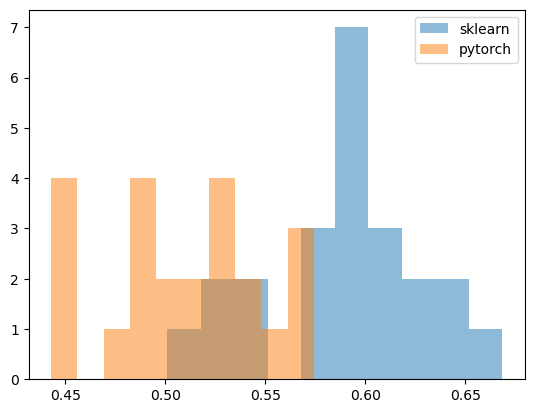

In [19]:
plt.hist(df['sklearn'], bins=10, label='sklearn', alpha=.5)
plt.hist(df['pytorch'], bins=10, label='pytorch', alpha=.5)
plt.legend()